# Examen práctico Series de Tiempo
## Mary Yuliana Jaramillo
### Maestría en Ciencia de Datos - Semestre II
### e-mail: maryyuliana@gmail.com

## 1. Carga de paquetes

In [422]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm
from pmdarima.arima import ARIMA

from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
import pandas as pd
import numpy as np 
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos 
import pylab as py
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


## 2 Cargar de datos

In [343]:
url ="https://raw.githubusercontent.com/maryyuliana/FUNDAMENTOS_DE_ANALITICA_II/master/Examen.csv"
df = pd.read_csv(url, delimiter=',', index_col= 'Unnamed: 0', )
df

,producto1,producto2
1,4000.000000,3000.000000
2,3997.400893,3010.686220
3,3978.605317,3022.018584
4,3986.454125,3033.920990
5,3979.695678,3038.402098
...,...,...
123,3664.610771,3429.293034
124,3650.881839,3437.099467
125,3651.788470,3453.155282
126,3637.047639,3472.528345


In [344]:
df.index = pd.date_range(start='1/1/2008', periods=len(df), freq='M')

# Imprimir el DataFrame con el nuevo índice
print(df)

              producto1    producto2
2008-01-31  4000.000000  3000.000000
2008-02-29  3997.400893  3010.686220
2008-03-31  3978.605317  3022.018584
2008-04-30  3986.454125  3033.920990
2008-05-31  3979.695678  3038.402098
...                 ...          ...
2018-03-31  3664.610771  3429.293034
2018-04-30  3650.881839  3437.099467
2018-05-31  3651.788470  3453.155282
2018-06-30  3637.047639  3472.528345
2018-07-31  3641.990873  3476.058092

[127 rows x 2 columns]


## 3.Análisis gráfico de la serie

### 3.1 Gráfico de las series

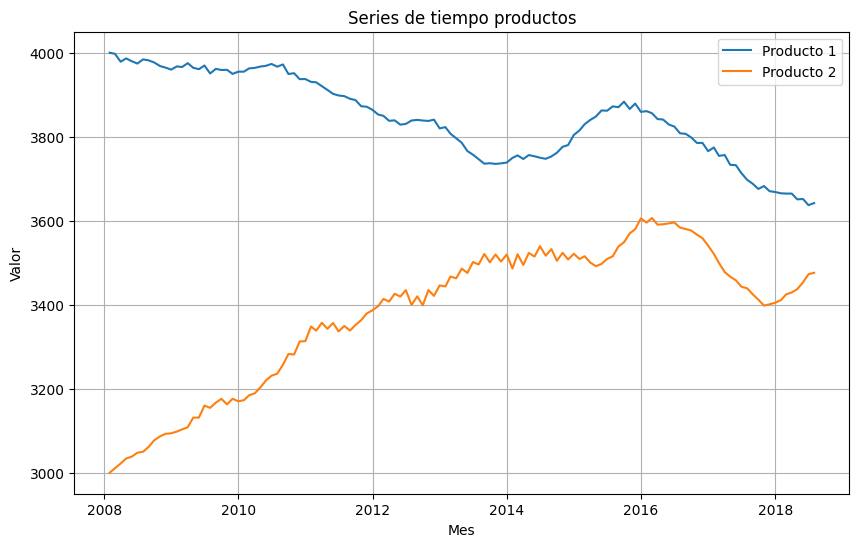

In [345]:

# Graficar las dos series de tiempo
plt.figure(figsize=(10, 6))  # Definir tamaño de la figura
plt.plot(df.index, df['producto1'], label='Producto 1')
plt.plot(df.index, df['producto2'], label='Producto 2')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Valor')
plt.title('Series de tiempo productos')
plt.grid(True)  # Agregar cuadrícula
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.show()


### 3.2 Descomposición de las series de tiempo

In [346]:

# Realizar la descomposición estacional con la frecuencia calculada
p1_componentes = seasonal_decompose(df['producto1'], model="additive")
p2_componentes = seasonal_decompose(df['producto2'], model="additive")

C:\Users\yulia\AppData\Local\Temp\ipykernel_9424\1418965874.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


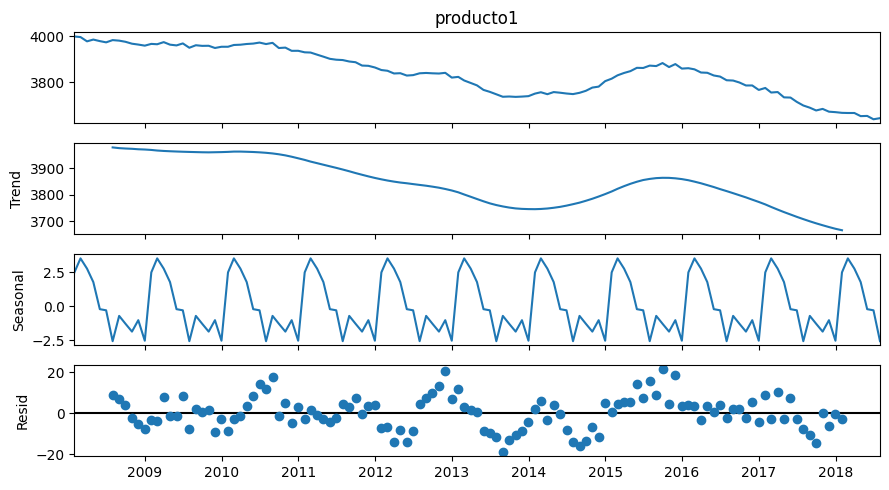

In [350]:

# Graficar los componentes de la serie del producto 1
fig = p1_componentes.plot()
fig.set_size_inches((9, 5))
fig.tight_layout()
plt.show()

En la serie de producto 1, se observa una tendencia no lineal y un estacionalidad, mientras que el ruido blano no es aleatorio alrededor de cero

C:\Users\yulia\AppData\Local\Temp\ipykernel_9424\3013840076.py:4: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


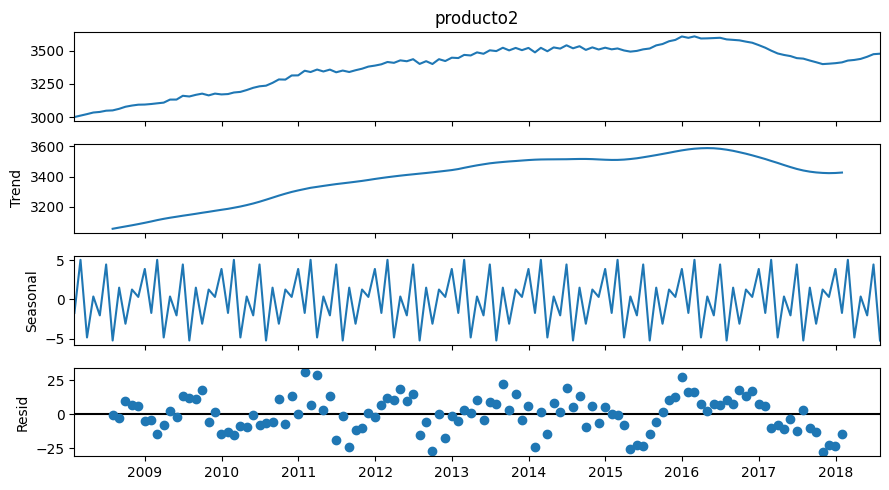

In [351]:
# Graficar los componentes de la serie del producto 2
fig = p2_componentes.plot()
fig.set_size_inches((9, 5))
fig.tight_layout()
plt.show()

La serie del producto 2, pareciera que tuviera una tendencia multiplicativa, la estacionalidad no es claramente marcada y un ruido blanco que no es aleatorio.

## 4. Desestacionalización de las series de tiempo

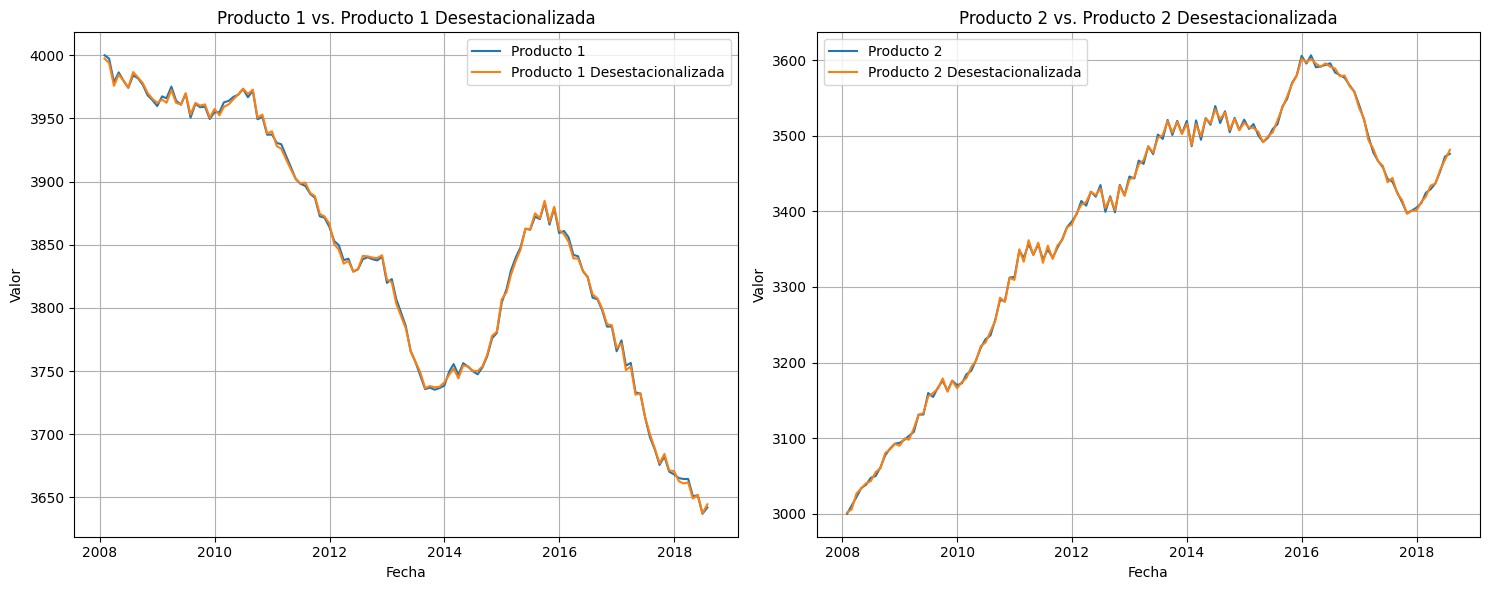

In [352]:
p1_desestacionalizada = df["producto1"]-p1_componentes.seasonal
p2_desestacionalizada = df["producto2"]-p2_componentes.seasonal

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Graficar producto1 y su versión desestacionalizada en la primera subgráfica
axes[0].plot(df['producto1'], label='Producto 1')
axes[0].plot(p1_desestacionalizada, label='Producto 1 Desestacionalizada')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor')
axes[0].set_title('Producto 1 vs. Producto 1 Desestacionalizada')
axes[0].legend()
axes[0].grid(True)

# Graficar producto2 y su versión desestacionalizada en la segunda subgráfica
axes[1].plot(df['producto2'], label='Producto 2')
axes[1].plot(p2_desestacionalizada, label='Producto 2 Desestacionalizada')
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valor')
axes[1].set_title('Producto 2 vs. Producto 2 Desestacionalizada')
axes[1].legend()
axes[1].grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

# 4. Modelos de suavizamiento

### 4.1 Modelos de medias móviles

In [353]:
# H: Tamaño del test
# W: Tamaño de la ventana
# m: Orden de la media móvil
def pto_eval_ma(indice_serie,H, W, m):

    H = round(H)
    W = round(W)
    m= round(m)
    indice_serie = round(indice_serie)
    data = df.iloc[:,[indice_serie]]
    #mejores_rmse = float('inf')  # Inicializar con un valor grande
    #mejor_m = None

      
    RMSE_ma = []

    for i in range(1, W):  
        dat_train_ma = data.iloc[i:len(data)-H-(W+i)]
        dat_test_ma = data.iloc[len(data)-W+i]

        mod_ma = dat_train_ma.rolling(m, min_periods=2).mean()  # Uso del valor de m actual
        prediccion_ma = mod_ma.iloc[-1]

        RMSE_ma_i = np.sqrt(mean_squared_error([dat_test_ma], [prediccion_ma]))
        RMSE_ma.append(RMSE_ma_i)

    promedio_rmse = np.mean(RMSE_ma)

    #if promedio_rmse < mejores_rmse:
     
     #   mejores_rmse = promedio_rmse
        #mejor_m = valor_m  # Uso del valor de m actual

    #return mejores_rmse, mejor_m
    return -promedio_rmse



In [362]:
pbounds_ma_producto1 = {'indice_serie':(0.1, 0.42),'H':(1, 1.1), 'W': (6, 6.1), 'm': (2, 6.1)}

In [355]:
pbounds_ma_producto2 = {'indice_serie':(0.51, 0.6),'H':(1, 1.1), 'W': (6, 6.1), 'm': (2, 6.1)}

In [363]:
optimizer_ma_p1 = BayesianOptimization(
    f=pto_eval_ma,
    pbounds=pbounds_ma_producto1,
    random_state=1,
    verbose=2
)

In [364]:
optimizer_ma_p1.maximize(init_points=2, n_iter=50)

|   iter    |  target   |     H     |     W     | indice... |     m     |
-------------------------------------------------------------------------
| 1         | -42.56    | 1.042     | 6.072     | 0.1       | 3.24      |
| 2         | -42.56    | 1.015     | 6.009     | 0.1596    | 3.417     |
| 3         | -59.52    | 1.073     | 6.072     | 0.3586    | 6.1       |
| 4         | -37.82    | 1.0       | 6.0       | 0.42      | 2.0       |
| 5         | -37.82    | 1.1       | 6.1       | 0.1       | 2.0       |
| 6         | -37.82    | 1.0       | 6.0       | 0.1       | 2.0       |


| 7         | -37.82    | 1.1       | 6.0       | 0.42      | 2.391     |
| 8         | -37.82    | 1.0       | 6.1       | 0.42      | 2.312     |
| 9         | -37.82    | 1.1       | 6.0       | 0.1       | 2.257     |
| 10        | -37.82    | 1.1       | 6.0       | 0.3119    | 2.125     |
| 11        | -37.82    | 1.0       | 6.1       | 0.1       | 2.168     |
| 12        | -37.82    | 1.0       | 6.0       | 0.42      | 2.302     |
| 13        | -37.82    | 1.1       | 6.099     | 0.4115    | 2.043     |
| 14        | -37.82    | 1.001     | 6.087     | 0.2534    | 2.012     |
| 15        | -37.82    | 1.0       | 6.1       | 0.42      | 2.129     |
| 16        | -42.56    | 1.0       | 6.0       | 0.42      | 2.599     |
| 17        | -47.81    | 1.1       | 6.1       | 0.1       | 4.445     |
| 18        | -37.82    | 1.1       | 6.1       | 0.1       | 2.454     |
| 19        | -47.81    | 1.1       | 6.1       | 0.42      | 3.832     |
| 20        | -37.82    | 1.098     | 

In [365]:
optimizer_ma_p1.max

{'target': -37.82124113023301,
 'params': {'H': 1.0, 'W': 6.0, 'indice_serie': 0.42, 'm': 2.0}}

In [367]:
optimizer_ma_p2 = BayesianOptimization(
    f=pto_eval_ma,
    pbounds=pbounds_ma_producto2,
    random_state=1,
    verbose=2
)

In [368]:
optimizer_ma_p2.maximize(init_points=2, n_iter=50)

|   iter    |  target   |     H     |     W     | indice... |     m     |
-------------------------------------------------------------------------
| 1         | -29.07    | 1.042     | 6.072     | 0.51      | 3.24      |
| 2         | -29.07    | 1.015     | 6.009     | 0.5268    | 3.417     |
| 3         | -12.64    | 1.073     | 6.072     | 0.5827    | 6.1       |
| 4         | -18.24    | 1.1       | 6.1       | 0.51      | 5.372     |
| 5         | -12.64    | 1.007     | 6.002     | 0.5104    | 6.079     |
| 6         | -12.64    | 1.0       | 6.0       | 0.6       | 6.1       |


| 7         | -12.64    | 1.0       | 6.1       | 0.51      | 6.1       |
| 8         | -12.64    | 1.1       | 6.0       | 0.51      | 6.1       |
| 9         | -12.64    | 1.0       | 6.0       | 0.51      | 6.1       |
| 10        | -12.64    | 1.1       | 6.1       | 0.51      | 6.1       |
| 11        | -12.64    | 1.006     | 6.098     | 0.5902    | 6.005     |
| 12        | -12.64    | 1.1       | 6.0       | 0.6       | 5.991     |
| 13        | -12.64    | 1.097     | 6.088     | 0.5182    | 6.0       |
| 14        | -12.64    | 1.1       | 6.1       | 0.6       | 6.024     |
| 15        | -12.64    | 1.0       | 6.1       | 0.6       | 6.1       |
| 16        | -12.64    | 1.054     | 6.047     | 0.5597    | 6.047     |
| 17        | -12.64    | 1.0       | 6.0       | 0.51      | 5.952     |
| 18        | -12.64    | 1.0       | 6.0       | 0.6       | 5.968     |
| 19        | -12.64    | 1.097     | 6.001     | 0.5161    | 5.989     |
| 20        | -12.64    | 1.001     | 

In [369]:
optimizer_ma_p2.max

{'target': -12.64198199628363,
 'params': {'H': 1.0733044243337495,
  'W': 6.072131661393158,
  'indice_serie': 0.5827382610440696,
  'm': 6.099590394199488}}

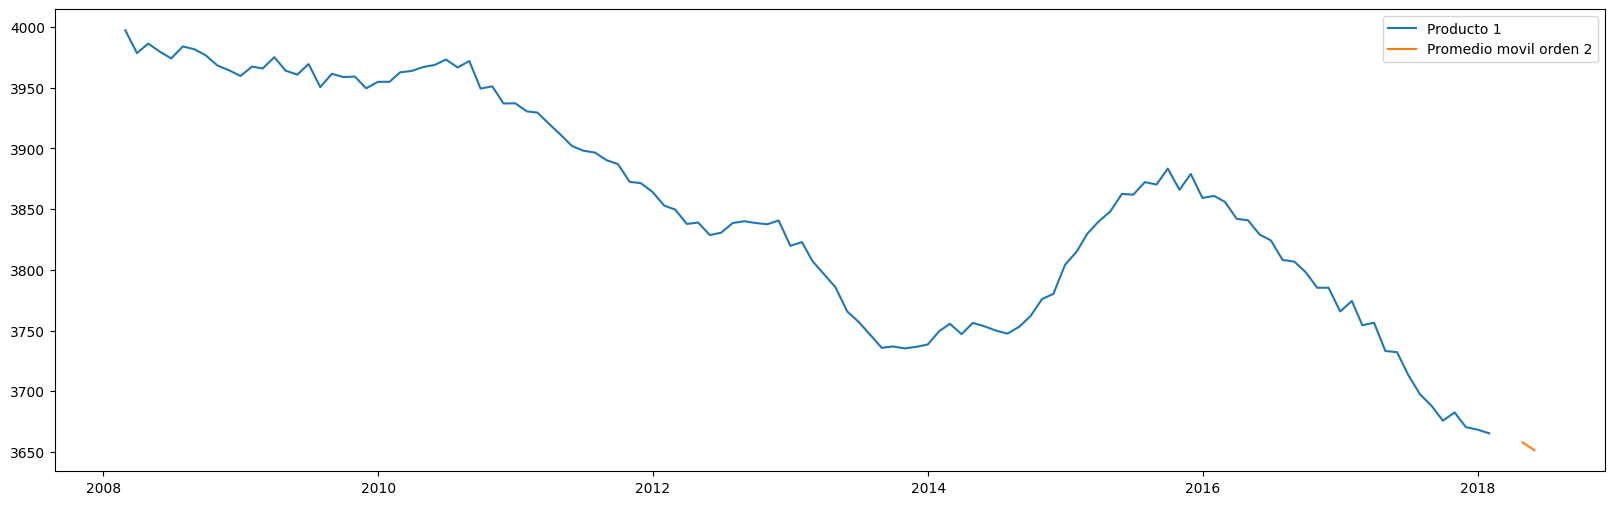

In [370]:
df_train = df.iloc[1:121]
df_test = df.iloc[122:125]

fig = plt.figure(figsize=(20, 6))
plt.plot(df_train['producto1'],label="Producto 1")
plt.plot(df_test['producto1'].rolling(2, min_periods=2).mean(),label="Promedio movil orden 2")
plt.legend()
plt.show()

## 4.2 Modelo exponencial Holt - Winters


In [373]:
# H: Tamaño del test
# W: Tamaño de la ventana
# Tendencia: tipo de tendencia aditiva o multiplicativa
# error: tipo de error aditivo o multiplicativo
# estacionalidad: Tipo de estacionalidad aditivo o multiplicativo

def pto_eval_hw(indice_serie, H, W, error, trend, seasonal, alpha, beta, gamma):
    
       
    error_types = ["add", "mul"]
    trend_types = ["add", "mul", None]
    seasonal_types = ["add", "mul", None]
    
    H = round(H)
    W = round(W)
    indice_serie = round(indice_serie)
    data = df.iloc[:,indice_serie]

    alpha = round(alpha,2)
    beta = round(beta,2)
    gamma = round(gamma,2)
    RMSE_hw = []
    
    for i in range(W):  
        dat_train_hw = data.iloc[i:len(data)-H-(W+i)]
        dat_test_hw = data.iloc[[len(data)-W+i]]

        mod_hw = ETSModel(endog=dat_train_hw, error=error_types[round(error)], trend=trend_types[round(trend)], seasonal=seasonal_types[round(seasonal)])
        
        params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

        if trend_types[round(trend)] == None:
            params.pop('smoothing_trend')
        if seasonal_types[round(seasonal)] == None:
            params.pop('smoothing_seasonal')
        
        model_result_hw = mod_hw.fit_constrained(params)

        # Generar múltiples pasos hacia adelante
        prediccion_hw = model_result_hw.forecast(H)

        # Calcular el RMSE para cada paso hacia adelante
        RMSE_hw_i = np.sqrt(mean_squared_error(dat_test_hw, prediccion_hw))
        RMSE_hw.append(RMSE_hw_i)

    # Calcular el promedio de los RMSE para todos los pasos hacia adelante
    promedio_rmse_hw = np.mean(RMSE_hw)

    return -promedio_rmse_hw

In [374]:
# pbouns Holt Winters serie producto 1
pbounds_hw_p1 = {'indice_serie':(0.1, 0.43),'H':(1, 1.1), 'W': (6, 6.1), 'error': (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99)}

In [376]:
optimizer_hw_p1 = BayesianOptimization(
    f=pto_eval_hw,
    pbounds= pbounds_hw_p1,
    random_state=1,
    verbose=2
)

In [386]:
optimizer_hw_p1.maximize(init_points=2, n_iter=50)

|   iter    |  target   |     H     |     W     |   alpha   |   beta    |   error   |   gamma   | indice... | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------------------------------------------


| 1         | -24.78    | 1.042     | 6.072     | 0.01011   | 0.3063    | 0.1468    | 0.1005    | 0.1615    | 0.6911    | 0.7935    |
| 2         | -20.44    | 1.054     | 6.042     | 0.6815    | 0.2104    | 0.8781    | 0.03684   | 0.3213    | 0.8346    | 1.117     |
| 3         | -1.407e+0 | 1.081     | 6.03      | 0.3901    | 0.7498    | 0.3977    | 0.9702    | 0.1372    | 1.258     | 1.348     |
| 4         | -20.67    | 1.047     | 6.058     | 0.3452    | 0.2468    | 0.5156    | 0.04759   | 0.2439    | 0.7514    | 0.9465    |
| 5         | -38.32    | 1.0       | 6.1       | 0.351     | 0.01      | 0.9257    | 0.01      | 0.43      | 0.0       | 0.02938   |
| 6         | -27.88    | 1.1       | 6.0       | 0.99      | 0.01      | 0.0       | 0.01      | 0.43      | 0.0       | 0.7285    |
| 7         | -198.2    | 1.0       | 6.1       | 0.01      | 0.01      | 1.0       | 0.01      | 0.43      | 0.0       | 1.652     |
| 8         | -25.75    | 1.0       | 6.1       | 0.99      | 

c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 17        | -33.5     | 1.0       | 6.1       | 0.99      | 0.01      | 1.0       | 0.99      | 0.1       | 0.0       | 0.0       |
| 18        | -26.01    | 1.034     | 6.074     | 0.9624    | 0.02515   | 0.9821    | 0.09518   | 0.1496    | 0.06471   | 1.224     |
| 19        | -24.07    | 1.0       | 6.0       | 0.01      | 0.99      | 0.0       | 0.01      | 0.1       | 0.0       | 0.0       |
| 20        | -198.2    | 1.0       | 6.1       | 0.01      | 0.01      | 0.0       | 0.01      | 0.43      | 0.0       | 2.0       |
| 21        | -22.92    | 1.1       | 6.1       | 0.99      | 0.99      | 0.0       | 0.01      | 0.43      | 2.0       | 0.0       |
| 22        | -25.34    | 1.0       | 6.0       | 0.99      | 0.99      | 1.0       | 0.01      | 0.43      | 0.9455    | 0.0       |
| 23        | -25.14    | 1.1       | 6.0       | 0.01      | 0.99      | 0.0       | 0.01      | 0.43      | 0.0       | 1.137     |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 24        | -27.58    | 1.0       | 6.1       | 0.01      | 0.99      | 1.0       | 0.01      | 0.43      | 2.0       | 0.0       |
| 25        | -28.63    | 1.0       | 6.1       | 0.99      | 0.01      | 1.0       | 0.01      | 0.43      | 2.0       | 2.0       |
| 26        | -29.99    | 1.0       | 6.1       | 0.99      | 0.99      | 1.0       | 0.01      | 0.43      | 0.0       | 2.0       |
| 27        | -39.51    | 1.0       | 6.0       | 0.01      | 0.01      | 0.0       | 0.99      | 0.43      | 0.0       | 0.0       |
| 28        | -209.2    | 1.0       | 6.0       | 0.01      | 0.01      | 1.0       | 0.01      | 0.1       | 0.0       | 0.7438    |
| 29        | -4.913e+0 | 1.1       | 6.1       | 0.01      | 0.99      | 1.0       | 0.99      | 0.43      | 0.0       | 0.0       |
| 30        | -29.77    | 1.0       | 6.0       | 0.99      | 0.99      | 0.0       | 0.01      | 0.43      | 1.268     | 1.909     |
| 31        | -25.04    | 1.07      | 6.034     | 0.9895    | 

In [387]:
optimizer_hw_p1.max

{'target': -19.618324881966526,
 'params': {'H': 1.0,
  'W': 6.0,
  'alpha': 0.01,
  'beta': 0.99,
  'error': 0.0,
  'gamma': 0.01,
  'indice_serie': 0.1,
  'seasonal': 1.24105937135168,
  'trend': 0.0}}

In [384]:
# pbouns Holt Winters serie producto 2
pbounds_hw_p2 = {'indice_serie':(0.56, 0.99),'H':(1, 1.1), 'W': (6, 6.1), 'error': (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99)}

In [388]:
## Optimizador para producto 2
optimizer_hw_p2 = BayesianOptimization(
    f=pto_eval_hw,
    pbounds= pbounds_hw_p2,
    random_state=1,
    verbose=2
)

In [389]:
optimizer_hw_p2.maximize(init_points=2, n_iter=50)

|   iter    |  target   |     H     |     W     |   alpha   |   beta    |   error   |   gamma   | indice... | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -32.68    | 1.042     | 6.072     | 0.01011   | 0.3063    | 0.1468    | 0.1005    | 0.6401    | 0.6911    | 0.7935    |
| 2         | -47.33    | 1.054     | 6.042     | 0.6815    | 0.2104    | 0.8781    | 0.03684   | 0.8483    | 0.8346    | 1.117     |
| 3         | -5.972e+0 | 1.081     | 6.03      | 0.3901    | 0.7498    | 0.3977    | 0.9702    | 0.6085    | 1.258     | 1.348     |
| 4         | -47.5     | 1.047     | 6.058     | 0.3448    | 0.248     | 0.5148    | 0.04967   | 0.747     | 0.7524    | 0.9472    |
| 5         | -14.86    | 1.0       | 6.1       | 0.3302    | 0.01      | 0.8975    | 0.01      | 0.99      | 0.0       | 0.03208   |
| 6         | -30.01    | 1.1       | 6.0       | 0.99      | 

c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 24        | -61.29    | 1.0       | 6.1       | 0.01      | 0.99      | 1.0       | 0.01      | 0.99      | 2.0       | 0.0       |
| 25        | -32.98    | 1.1       | 6.1       | 0.99      | 0.01      | 0.0       | 0.01      | 0.56      | 2.0       | 0.0       |
| 26        | -35.42    | 1.0       | 6.1       | 0.99      | 0.01      | 1.0       | 0.01      | 0.99      | 2.0       | 2.0       |
| 27        | -34.07    | 1.1       | 6.1       | 0.99      | 0.01      | 0.0       | 0.01      | 0.56      | 0.0       | 2.0       |
| 28        | -114.5    | 1.0       | 6.1       | 0.01      | 0.01      | 0.0       | 0.01      | 0.99      | 0.0       | 0.9264    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 29        | -33.59    | 1.1       | 6.0       | 0.99      | 0.01      | 0.0       | 0.99      | 0.99      | 0.0       | 0.0       |
| 30        | -39.41    | 1.1       | 6.1       | 0.01      | 0.99      | 1.0       | 0.01      | 0.99      | 0.0       | 2.0       |
| 31        | -59.39    | 1.1       | 6.1       | 0.01      | 0.01      | 1.0       | 0.99      | 0.56      | 0.0       | 0.0       |
| 32        | -46.24    | 1.0       | 6.1       | 0.01      | 0.99      | 0.0       | 0.01      | 0.56      | 0.0       | 0.0       |
| 33        | -8.072e+0 | 1.0       | 6.0       | 0.99      | 0.99      | 1.0       | 0.99      | 0.56      | 0.0       | 0.0       |
| 34        | -36.42    | 1.05      | 6.044     | 0.03485   | 0.5869    | 0.0383    | 0.6295    | 0.7715    | 1.71      | 0.3674    |
| 35        | -50.51    | 1.037     | 6.004     | 0.1023    | 0.3102    | 0.9867    | 0.5187    | 0.9182    | 0.9848    | 0.6166    |
| 36        | -49.9     | 1.061     | 6.056     | 0.6471    | 

In [390]:
optimizer_hw_p2.max

{'target': -14.863992775378847,
 'params': {'H': 1.0,
  'W': 6.1,
  'alpha': 0.33021702695589883,
  'beta': 0.01,
  'error': 0.8975151471058541,
  'gamma': 0.01,
  'indice_serie': 0.99,
  'seasonal': 0.0,
  'trend': 0.03207597865603932}}

## 4.3 Modelo lineales

Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación) 

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).

In [391]:
producto1 =  df[['producto1']]
producto2 = df[['producto2']]

In [392]:
## Se revisa si existe autocorrelación o no en las series de tiempo del producto 1
runstest_1samp(producto1, cutoff = 'median' ,correction=False)
runstest_1samp(producto1, cutoff = 'mean' ,correction=False)

(-10.779180311358557, 4.317155645915911e-27)

In [393]:
## Se revisa si existe autocorrelación o no en las series de tiempo del producto 1
runstest_1samp(producto2, cutoff = 'median' ,correction=False)
runstest_1samp(producto2, cutoff = 'mean' ,correction=False)

(-11.129783217479355, 8.985375985449137e-29)

In [394]:
# Prueba de Ljung-Box producto 1

lb_bp_producto1 = sm.stats.acorr_ljungbox(producto1, lags=range(1,21), return_df=True,boxpierce=True )
lb_bp_producto1["lb_ho"] = np.where(lb_bp_producto1['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
lb_bp_producto1["bp_ho"] = np.where(lb_bp_producto1['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

lb_bp_producto1

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,122.203107,2.083759e-28,119.361175,8.729583e-28,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,237.486963,2.693775e-52,231.070337,6.663677e-51,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,345.694890,1.275986e-74,335.084158,2.530503e-72,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,446.232479,2.833490e-95,430.945581,5.711622e-92,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,539.298598,2.616820e-114,518.961600,6.440955e-110,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,624.725114,1.080771e-131,599.090348,3.664193e-126,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,702.281402,2.222041e-147,671.235732,1.094679e-140,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,771.886015,2.354398e-161,735.444639,1.667948e-153,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,834.016515,1.009552e-173,792.277188,9.769214e-165,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,889.132554,1.389218e-184,842.266154,1.682013e-174,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


In [395]:
# Prueba de Ljung-Box producto 2

lb_bp_producto2 = sm.stats.acorr_ljungbox(producto2, lags=range(1,21), return_df=True,boxpierce=True )
lb_bp_producto2["lb_ho"] = np.where(lb_bp_producto2['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
lb_bp_producto2["bp_ho"] = np.where(lb_bp_producto2['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
lb_bp_producto2

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,123.254838,1.226409e-28,120.388447,5.201076e-28,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,241.757761,3.183972e-53,235.216860,8.381232e-52,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,354.239891,1.801336e-76,343.339218,4.129499e-74,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,461.807685,1.216308e-98,445.903858,3.337047e-95,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,563.370513,1.655648e-119,541.955525,6.982631e-115,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,659.914186,2.754055e-139,632.511994,2.257146e-133,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,750.621017,8.356274e-158,716.890441,1.573007e-150,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,836.489298,2.804889e-175,796.102266,1.424072e-166,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,917.200763,1.216413e-191,869.931358,1.858894e-181,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,993.576163,4.525378e-207,939.202070,2.318857e-195,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


Para el caso de las dos series de tiempo se rechaza la hipotesis nula, por lo tanto la series si presentan autocorrelación

#### Se desarrolla un comparación entre modelos lineales con tendencia  cúbica y estacionalidad

##### Modelo cúbico sin estacionalidad

In [396]:
def modelo_ml_cubico(indice_serie, W, data):
    if indice_serie == 0:
        y = "producto1"
    else:
        y = "producto2"
    
    datos = data.iloc[:, [indice_serie]].copy()
    n = datos.shape[0]
    RMSE_lm = []

    for counter in range(0, W):
        data_slice = datos.iloc[counter : counter + n - W].copy()
        dat_test = datos.iloc[counter + n- W].copy() #localiza un dato
        data_slice['x'] = np.linspace(counter + 1, counter + n-W, n-W)
        data_slice['x2'] = data_slice['x']**2
        data_slice['x3'] = data_slice['x']**3
        X = sm.add_constant(data_slice[['x', 'x2', 'x3']])
        #print(X)
        mod_lm = sm.OLS(data_slice[y], X)
        #print(data_slice[y])
        mod_lm_fitted = mod_lm.fit()
        x_for = np.array([1, counter + n - W + 1, (counter + n - W + 1)**2, (counter + n - W + 1)**3])
        #print(x_for)
        pred_lm = mod_lm_fitted.predict(x_for)
        #print(pred_lm)
        RMSE_lm.append(np.sqrt(mean_squared_error(dat_test, pred_lm)))
        promedio_RMSE_lm = np.mean(np.array(RMSE_lm))

        
    return -promedio_RMSE_lm

# Ejemplo de uso
# Suponiendo que tienes un DataFrame df y deseas calcular el modelo para la primera serie (indice_serie=0) con una ventana W de 5
# resultado = modelo_ml_cubico(0, 5, df)


In [397]:
resutados_lm_producto1 = modelo_ml_cubico(0,6,df)
resutados_lm_producto1

-45.562156796769536

In [398]:
resutados_lm_producto2 = modelo_ml_cubico(1,6,df)
resutados_lm_producto2

-57.245426140867494

In [399]:
dummies = pd.get_dummies(df.index.month,drop_first=True,dtype=int).set_index(df.index)  # Suponiendo que 'categoria' es la columna con las categorías
    

In [400]:
dummies

,2,3,4,5,6,7,8,9,10,11,12
2008-01-31,0,0,0,0,0,0,0,0,0,0,0
2008-02-29,1,0,0,0,0,0,0,0,0,0,0
2008-03-31,0,1,0,0,0,0,0,0,0,0,0
2008-04-30,0,0,1,0,0,0,0,0,0,0,0
2008-05-31,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31,0,1,0,0,0,0,0,0,0,0,0
2018-04-30,0,0,1,0,0,0,0,0,0,0,0
2018-05-31,0,0,0,1,0,0,0,0,0,0,0
2018-06-30,0,0,0,0,1,0,0,0,0,0,0


##### Modelo cúbico con estacionalidad



In [401]:

def modelo_ml_cubico_est(indice_serie, W, data):
    if indice_serie == 0:
        y = "producto1"
    else:
        y = "producto2"
    
    datos = data.iloc[:, [indice_serie]].copy()
    
    # Obtener variables ficticias
    
    n = datos.shape[0]
    RMSE_lm = []

    for counter in range(0,  W):
        data_slice = datos.iloc[counter : counter + n - W].copy()
        dat_test = datos.iloc[counter + n - W].copy()
        data_slice['x'] = np.linspace(counter + 1, counter + n-W, n-W)
        data_slice['x2'] = data_slice['x']**2
        data_slice['x3'] = data_slice['x']**3
        
        dummy = dummies.iloc[counter : counter + n-W]  # Seleccionar las filas correctas de 'dummies'
        
        # Construir la matriz de diseño 'X' correctamente
        print(pd.concat([data_slice[['x', 'x2', 'x3']], dummy], axis=1))
        X = sm.add_constant(pd.concat([data_slice[['x', 'x2', 'x3']], dummy], axis=1))
        
        
        mod_lm = sm.OLS(data_slice[y], X)
        mod_lm_fitted = mod_lm.fit()
        
        x_for_estacional = pd.DataFrame([[1, counter + n - W + 1, (counter + n - W + 1)**2, (counter + n - W + 1)**3]], 
                                        columns=['const', 'x', 'x2', 'x3'])
        
        # Seleccionar la fila correcta de 'dummy' para agregarla a la predicción
        dummy_row = dummies.iloc[counter + W].to_numpy().reshape(1, -1)
        
        pred_lm = mod_lm_fitted.predict(sm.add_constant(pd.concat([x_for_estacional, pd.DataFrame(dummy_row, columns=dummy.columns)], axis=1)))
        
        RMSE_lm.append(np.sqrt(mean_squared_error(dat_test, pred_lm)))
    
    # Calcular el promedio de los RMSE
    promedio_RMSE_lm = np.mean(RMSE_lm)

    return -promedio_RMSE_lm

In [402]:
resutados_lm_est_producto1 = modelo_ml_cubico_est(0,6,df)
resutados_lm_est_producto1

                x       x2         x3  2  3  4  5  6  7  8  9  10  11  12
2008-01-31    1.0      1.0        1.0  0  0  0  0  0  0  0  0   0   0   0
2008-02-29    2.0      4.0        8.0  1  0  0  0  0  0  0  0   0   0   0
2008-03-31    3.0      9.0       27.0  0  1  0  0  0  0  0  0   0   0   0
2008-04-30    4.0     16.0       64.0  0  0  1  0  0  0  0  0   0   0   0
2008-05-31    5.0     25.0      125.0  0  0  0  1  0  0  0  0   0   0   0
...           ...      ...        ... .. .. .. .. .. .. .. ..  ..  ..  ..
2017-09-30  117.0  13689.0  1601613.0  0  0  0  0  0  0  0  1   0   0   0
2017-10-31  118.0  13924.0  1643032.0  0  0  0  0  0  0  0  0   1   0   0
2017-11-30  119.0  14161.0  1685159.0  0  0  0  0  0  0  0  0   0   1   0
2017-12-31  120.0  14400.0  1728000.0  0  0  0  0  0  0  0  0   0   0   1
2018-01-31  121.0  14641.0  1771561.0  0  0  0  0  0  0  0  0   0   0   0

[121 rows x 14 columns]
                x       x2         x3  2  3  4  5  6  7  8  9  10  11  12
2008-02-29   

-44.46686295765593

In [403]:
resutados_lm_est_producto2 = modelo_ml_cubico_est(1,6,df)
resutados_lm_est_producto2

                x       x2         x3  2  3  4  5  6  7  8  9  10  11  12
2008-01-31    1.0      1.0        1.0  0  0  0  0  0  0  0  0   0   0   0
2008-02-29    2.0      4.0        8.0  1  0  0  0  0  0  0  0   0   0   0
2008-03-31    3.0      9.0       27.0  0  1  0  0  0  0  0  0   0   0   0
2008-04-30    4.0     16.0       64.0  0  0  1  0  0  0  0  0   0   0   0
2008-05-31    5.0     25.0      125.0  0  0  0  1  0  0  0  0   0   0   0
...           ...      ...        ... .. .. .. .. .. .. .. ..  ..  ..  ..
2017-09-30  117.0  13689.0  1601613.0  0  0  0  0  0  0  0  1   0   0   0
2017-10-31  118.0  13924.0  1643032.0  0  0  0  0  0  0  0  0   1   0   0
2017-11-30  119.0  14161.0  1685159.0  0  0  0  0  0  0  0  0   0   1   0
2017-12-31  120.0  14400.0  1728000.0  0  0  0  0  0  0  0  0   0   0   1
2018-01-31  121.0  14641.0  1771561.0  0  0  0  0  0  0  0  0   0   0   0

[121 rows x 14 columns]
                x       x2         x3  2  3  4  5  6  7  8  9  10  11  12
2008-02-29   

-59.25465246469321

# Modelo ARIMA


In [404]:
# H: Tamaño del test
# W: Tamaño de la ventana
# m: Orden de la media móvil
def pto_eval_arima(indice_serie,H, W, P,I,Q):

    H = round(H)
    W = round(W)
    P= round(P)
    I= round(I)
    Q= round(Q)

    indice_serie = round(indice_serie)
    data = df.iloc[:,[indice_serie]]
    #mejores_rmse = float('inf')  # Inicializar con un valor grande
    #mejor_m = None
      
    RMSE_ma = []
    for i in range(1, W):  
        dat_train_ma = data.iloc[i:len(data)-H-(W+i)]
        dat_test_ma = data.iloc[len(data)-H-(W+i)]

        mod_ma = ARIMA(order=(P,I,Q))  # Uso del valor de m actual
        prediccion_ma = mod_ma.fit(dat_train_ma)
        prediccion = prediccion_ma.predict(H)

        RMSE_ma_i = np.sqrt(mean_squared_error([dat_test_ma], [prediccion]))
        RMSE_ma.append(RMSE_ma_i)

    promedio_rmse = np.mean(RMSE_ma)

    #if promedio_rmse < mejores_rmse:
     
     #   mejores_rmse = promedio_rmse
        #mejor_m = valor_m  # Uso del valor de m actual

    #return mejores_rmse, mejor_m
    return -promedio_rmse

In [405]:
# pbouns modelo ARIMA  serie producto 1
pbounds_arima_p1 = {'indice_serie':(0.1, 0.43),'H':(1, 1.1), 'W': (6, 6.1), 'P': (1,11),'I':(1,5) , 'Q': (1,11)}

In [406]:
optimizer_arima_p1 = BayesianOptimization(
    f= pto_eval_arima,
    pbounds=pbounds_arima_p1,
    random_state=1,
    verbose=2
)

In [407]:
optimizer_arima_p1.maximize(init_points=2,n_iter=50)

|   iter    |  target   |     H     |     I     |     P     |     Q     |     W     | indice... |
-------------------------------------------------------------------------------------------------


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 1         | -8.112    | 1.042     | 3.881     | 1.001     | 4.023     | 6.015     | 0.1305    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 2         | -6.739    | 1.019     | 2.382     | 4.968     | 6.388     | 6.042     | 0.3261    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 3         | -6.739    | 1.027     | 2.409     | 5.153     | 6.439     | 6.036     | 0.3231    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 4         | -6.725    | 1.0       | 1.0       | 4.348     | 10.37     | 6.1       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

| 5         | -6.65     | 1.0       | 1.0       | 9.734     | 11.0      | 6.1       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 6         | -8.921    | 1.0       | 5.0       | 7.686     | 11.0      | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

| 7         | -6.189    | 1.0       | 1.0       | 11.0      | 7.968     | 6.074     | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 8         | -6.164    | 1.0       | 1.0       | 10.33     | 4.362     | 6.1       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 9         | -10.42    | 1.1       | 4.628     | 11.0      | 1.0       | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 10        | -5.216    | 1.0       | 1.0       | 6.459     | 3.374     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 11        | -5.211    | 1.0       | 1.0       | 4.325     | 1.0       | 6.1       | 0.43      |
| 12        | -5.722    | 1.1       | 1.0       | 6.769     | 1.0       | 6.0       | 0.43      |
| 13        | -6.19     | 1.036     | 1.305     | 1.446     | 1.028     | 6.073     | 0.2671    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 14        | -5.361    | 1.1       | 1.0       | 4.411     | 3.051     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

| 15        | -7.239    | 1.0       | 1.0       | 7.528     | 5.718     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 16        | -7.745    | 1.0       | 3.354     | 5.159     | 1.869     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 17        | -8.006    | 1.09      | 3.721     | 1.075     | 10.93     | 6.054     | 0.313     |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  wa

| 18        | -8.626    | 1.1       | 4.568     | 11.0      | 7.165     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 19        | -4.947    | 1.0       | 1.0       | 5.603     | 2.179     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 20        | -5.641    | 1.1       | 1.0       | 1.0       | 7.43      | 6.0       | 0.1       |
| 21        | -5.621    | 1.0       | 1.0       | 1.0       | 4.877     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 22        | -5.279    | 1.1       | 1.0       | 5.092     | 1.859     | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 23        | -6.614    | 1.0       | 1.0       | 7.893     | 2.647     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 24        | -6.65     | 1.079     | 1.052     | 2.805     | 6.67      | 6.077     | 0.2635    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 25        | -5.531    | 1.0       | 1.0       | 5.306     | 4.171     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 26        | -5.828    | 1.033     | 1.07      | 1.224     | 10.86     | 6.013     | 0.1116    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

| 27        | -6.256    | 1.021     | 1.018     | 1.498     | 9.34      | 6.005     | 0.3868    |
| 28        | -5.46     | 1.0       | 1.0       | 2.176     | 2.992     | 6.1       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 29        | -5.216    | 1.0       | 1.0       | 5.718     | 3.065     | 6.1       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 30        | -6.045    | 1.0       | 1.0       | 11.0      | 5.899     | 6.0       | 0.1       |
| 31        | -5.806    | 1.0       | 1.0       | 5.503     | 1.0       | 6.1       | 0.43      |
| 32        | -5.266    | 1.047     | 1.044     | 3.013     | 1.625     | 6.1       | 0.3492    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 33        | -9.22     | 1.0       | 5.0       | 4.065     | 7.363     | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 34        | -6.045    | 1.0       | 1.0       | 2.971     | 4.337     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters

| 35        | -27.03    | 1.0       | 5.0       | 1.0       | 1.0       | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 36        | -7.398    | 1.0       | 3.767     | 1.0       | 6.7       | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 37        | -9.146    | 1.0       | 5.0       | 7.462     | 4.375     | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 38        | -8.499    | 1.1       | 5.0       | 11.0      | 11.0      | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 39        | -6.26     | 1.1       | 1.0       | 7.39      | 9.292     | 6.0       | 0.1       |
| 40        | -6.553    | 1.049     | 1.053     | 10.8      | 1.334     | 6.095     | 0.3404    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 41        | -6.526    | 1.022     | 1.056     | 6.343     | 10.92     | 6.089     | 0.1702    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

| 42        | -7.265    | 1.1       | 3.759     | 4.39      | 11.0      | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

| 43        | -6.934    | 1.1       | 2.617     | 5.755     | 3.917     | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 44        | -7.103    | 1.1       | 1.0       | 5.317     | 7.974     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 45        | -7.673    | 1.0       | 2.689     | 8.835     | 8.535     | 6.0       | 0.43      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

| 46        | -7.254    | 1.085     | 3.169     | 7.456     | 1.014     | 6.086     | 0.193     |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 47        | -8.077    | 1.1       | 2.827     | 11.0      | 4.19      | 6.0       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 48        | -6.444    | 1.1       | 2.45      | 1.0       | 5.148     | 6.0       | 0.43      |
| 49        | -7.485    | 1.06      | 1.025     | 1.074     | 2.378     | 6.069     | 0.3567    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 50        | -7.02     | 1.054     | 2.037     | 10.89     | 10.23     | 6.1       | 0.1033    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 51        | -7.948    | 1.0       | 2.994     | 2.861     | 4.582     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 52        | -5.641    | 1.0       | 1.0       | 9.228     | 7.618     | 6.1       | 0.1       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [408]:
optimizer_arima_p1.max

{'target': -4.946750428355972,
 'params': {'H': 1.0,
  'I': 1.0,
  'P': 5.60301078977635,
  'Q': 2.1790996116209467,
  'W': 6.0,
  'indice_serie': 0.43}}

In [409]:
# pbouns modelo ARIMA  serie producto 1
pbounds_arima_p2 = {'indice_serie':(0.56,1),'H':(1, 1.1), 'W': (6, 6.1), 'P': (1,11),'I':(1,5) , 'Q': (1,11)}

In [410]:
## optimizador arima producto 2

optimizer_arima_p2 = BayesianOptimization(
    f= pto_eval_arima,
    pbounds=pbounds_arima_p2,
    random_state=1,
    verbose=2
)

In [411]:
optimizer_arima_p2.maximize(init_points=2,n_iter=50)

|   iter    |  target   |     H     |     I     |     P     |     Q     |     W     | indice... |
-------------------------------------------------------------------------------------------------


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

| 1         | -8.953    | 1.042     | 3.881     | 1.001     | 4.023     | 6.015     | 0.6006    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 2         | -9.66     | 1.019     | 2.382     | 4.968     | 6.388     | 6.042     | 0.8615    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn(

| 3         | -8.953    | 1.029     | 3.841     | 1.215     | 4.096     | 6.084     | 0.8009    |
| 4         | -12.63    | 1.0       | 1.411     | 1.0       | 1.0       | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 5         | -10.36    | 1.1       | 5.0       | 1.0       | 7.073     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

| 6         | -9.971    | 1.1       | 5.0       | 3.838     | 3.788     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 7         | -8.949    | 1.0       | 1.684     | 1.03      | 5.842     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 8         | -10.01    | 1.0       | 1.0       | 1.806     | 8.704     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 9         | -9.078    | 1.0       | 1.0       | 9.236     | 7.257     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 10        | -9.994    | 1.0       | 3.29      | 9.355     | 8.894     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 11        | -9.991    | 1.0       | 1.0       | 8.971     | 4.685     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.

| 12        | -10.49    | 1.1       | 1.0       | 7.122     | 8.388     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 13        | -9.169    | 1.1       | 2.432     | 2.467     | 5.088     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn

| 14        | -11.21    | 1.1       | 1.0       | 11.0      | 7.782     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 15        | -8.805    | 1.1       | 3.006     | 1.0       | 5.217     | 6.0       | 0.56      |
| 16        | -9.505    | 1.062     | 1.251     | 1.066     | 4.38      | 6.055     | 0.8147    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 17        | -9.567    | 1.0       | 2.835     | 8.431     | 6.381     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 18        | -13.14    | 1.1       | 5.0       | 11.0      | 1.0       | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 19        | -9.753    | 1.0       | 5.0       | 5.238     | 11.0      | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 20        | -13.69    | 1.0       | 5.0       | 1.0       | 11.0      | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 21        | -10.04    | 1.0       | 5.0       | 6.396     | 7.947     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 22        | -10.68    | 1.0       | 5.0       | 8.371     | 11.0      | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 23        | -9.272    | 1.0       | 1.0       | 5.528     | 3.764     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 24        | -9.837    | 1.0       | 1.0       | 6.68      | 1.0       | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 25        | -10.63    | 1.083     | 4.762     | 5.361     | 1.001     | 6.092     | 0.7823    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 26        | -9.925    | 1.066     | 1.024     | 3.015     | 6.288     | 6.08      | 0.9044    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

| 27        | -10.23    | 1.0       | 3.113     | 6.294     | 4.179     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 28        | -9.43     | 1.0       | 1.0       | 7.216     | 5.9       | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 29        | -8.838    | 1.0       | 5.0       | 11.0      | 7.005     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 30        | -9.113    | 1.1       | 5.0       | 9.32      | 6.321     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 31        | -8.338    | 1.1       | 5.0       | 11.0      | 8.999     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

| 32        | -11.29    | 1.0       | 5.0       | 11.0      | 11.0      | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 33        | -11.03    | 1.1       | 5.0       | 9.955     | 8.118     | 6.1       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 34        | -6.992    | 1.0       | 4.788     | 10.73     | 5.62      | 6.093     | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 35        | -7.993    | 1.1       | 3.907     | 10.87     | 5.501     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 36        | -7.856    | 1.0       | 5.0       | 10.56     | 4.825     | 6.1       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 37        | -6.992    | 1.1       | 5.0       | 11.0      | 5.708     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 38        | -8.873    | 1.0       | 4.591     | 10.35     | 5.712     | 6.0       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 39        | -7.856    | 1.001     | 4.707     | 10.93     | 5.195     | 6.042     | 0.922     |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 40        | -6.992    | 1.1       | 5.0       | 11.0      | 6.037     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 41        | -7.825    | 1.02      | 4.802     | 9.451     | 4.225     | 6.079     | 0.9612    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting pa

| 42        | -9.604    | 1.063     | 4.921     | 8.238     | 4.621     | 6.051     | 0.7272    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 43        | -10.06    | 1.1       | 3.723     | 9.953     | 3.959     | 6.1       | 1.0       |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 44        | -11.68    | 1.003     | 3.327     | 10.97     | 6.591     | 6.039     | 0.9481    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 45        | -7.205    | 1.0       | 5.0       | 10.09     | 3.757     | 6.1       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 46        | -8.321    | 1.06      | 4.958     | 9.396     | 3.057     | 6.083     | 0.81      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inve

| 47        | -6.681    | 1.044     | 4.933     | 10.93     | 3.62      | 6.006     | 0.9217    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 48        | -9.914    | 1.1       | 5.0       | 11.0      | 3.129     | 6.1       | 0.56      |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 49        | -6.681    | 1.068     | 4.947     | 10.98     | 4.164     | 6.001     | 0.6522    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

| 50        | -6.681    | 1.059     | 4.837     | 10.62     | 4.344     | 6.095     | 0.9583    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as

| 51        | -11.03    | 1.091     | 4.479     | 10.61     | 3.905     | 6.068     | 0.8168    |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 52        | -9.443    | 1.003     | 2.22      | 1.545     | 6.974     | 6.078     | 0.677     |


c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [341]:
optimizer_arima_p2.max

{'target': -6.681479755810597,
 'params': {'H': 1.0438862343239708,
  'I': 4.933396286717241,
  'P': 10.932675536558465,
  'Q': 3.619824381938426,
  'W': 6.0055100353688795,
  'indice_serie': 0.9216556421404661}}

In [412]:
## Validación de supuestos 

modelo_final_p1 = ARIMA(order = (6,1,2))
results_final_p1 = modelo_final_p1.fit(df['producto1'])
residuals_p1 = results_final_p1.resid()


In [413]:
modelo_final_p2 = ARIMA(order = (11,4,4))
results_final_p2 = modelo_final_p2.fit(df['producto2'])
residuals_p2 = results_final_p2.resid()

c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\yulia\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [414]:
### Prueba de autorcorrelación de los residuales
runstest_1samp(residuals_p1 > 0, correction = False)

(0.8387507568432431, 0.40160918914743204)

In [415]:
runstest_1samp(residuals_p2 > 0, correction = False)

(-0.08839391559362308, 0.9295635970210765)

In [416]:
### Homocedasticidad

sm.stats.acorr_ljungbox((residuals_p1)**2, lags=range(1,21), return_df=True,boxpierce=True ) 

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,5.613331e-07,0.999402,5.482789e-07,0.999409
2,2.218310e-06,0.999999,2.153877e-06,0.999999
3,6.686844e-06,1.000000,6.449212e-06,1.000000
4,1.497122e-05,1.000000,1.434827e-05,1.000000
5,2.815953e-05,1.000000,2.682093e-05,1.000000
6,4.678063e-05,1.000000,4.428724e-05,1.000000
7,7.312975e-05,1.000000,6.879805e-05,1.000000
8,1.069803e-04,1.000000,1.000245e-04,1.000000
9,1.507949e-04,1.000000,1.401030e-04,1.000000
10,2.059598e-04,1.000000,1.901363e-04,1.000000


In [425]:
### HOMOCEDASTICIDAD
sm.stats.acorr_ljungbox((residuals_p2)**2, lags=range(1,21), return_df=True,boxpierce=True ) 

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,26.891526,2.152004e-07,26.266142,2.974581e-07
2,27.106737,1.299711e-06,26.474679,1.782775e-06
3,27.106737,5.591679e-06,26.474679,7.586018e-06
4,27.106768,1.891490e-05,26.474709,2.538161e-05
5,27.106823,5.437405e-05,26.474761,7.217280e-05
6,27.106901,1.382798e-04,26.474834,1.815651e-04
7,27.107007,3.188179e-04,26.474933,4.141288e-04
8,27.107147,6.774878e-04,26.475062,8.706488e-04
9,27.107324,1.342713e-03,26.475224,1.707285e-03
10,27.107548,2.504220e-03,26.475427,3.150733e-03


In [423]:

## Normalidad
stats.shapiro(residuals_p1)

ShapiroResult(statistic=0.07277804613113403, pvalue=9.867318721537297e-25)

In [424]:
stats.shapiro(residuals_p2)

ShapiroResult(statistic=0.16891223192214966, pvalue=1.2053973703202546e-23)

In [ ]:
{'target': -19.618324881966526,
 'params': {'H': 1.0,
  'W': 6.0,
  'alpha': 0.01,
  'beta': 0.99,
  'error': 0.0,
  'gamma': 0.01,
  'indice_serie': 0.1,
  'seasonal': 1.24105937135168,
  'trend': 0.0}}

In [434]:

# Define and fit the ETS model
ets_model = ETSModel(endog=df["producto1"], error="add", trend="mul", seasonal=None)
ets_result = ets_model.fit_constrained({'smoothing_level': 0.01,
                                        'smoothing_trend': 0.99})

# Make one-step ahead forecast
point_forecast = ets_result.forecast(steps=1)

# Get prediction intervals
ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)

# Organize forecast results
limits = ci.predicted_mean
preds_hw_add = pd.concat([limits, conf_forecast], axis=1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)


            Point_forecast     lower_95     upper_95
2018-08-31     3606.912427  3567.709103  3645.001135


In [437]:
ets_model = ETSModel(endog=df["producto2"], error="mul", trend="add", seasonal=None)
ets_result = ets_model.fit_constrained({'smoothing_level': 0.330217,
                                        'smoothing_trend': 0.01})

# Make one-step ahead forecast
point_forecast = ets_result.forecast(steps=1)

# Get prediction intervals
ci = ets_result.get_prediction(start=point_forecast.index[0], end=point_forecast.index[-1])
conf_forecast = ci.pred_int(alpha=0.05)

# Organize forecast results
limits = ci.predicted_mean
preds_hw_add = pd.concat([limits, conf_forecast], axis=1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast     lower_95     upper_95
2018-08-31     3454.190253  3411.201222  3497.364205
